# Adding Basic Components (v4.0)

## Creating a new Feb object

### The basics

We can create a new FEB file with basically no information. To do so, we can simply call Feb and provide it a version. Right now, we accept versions 2.5 and 3.0.

In [1]:
from febio_python import Feb
from febio_python.feb import Feb40 # for type hinting

feb: Feb40 = Feb(version=4.0)
feb

Feb40(4.0):
-> Module: Unknown
-> Control: 0
-> Material: 0
-> Globals: 0
-> Mesh: 0
-> MeshDomains: 0
-> MeshData: 0
-> Boundary: 0
-> Loads: 0
-> Discrete: 0
-> LoadData: 0
-> Output: 0

You will notices that all contents of the feb file are zero. This means that there is nothing stored in the feb right now. Let's start modifying it. We will begin with simple structures, like module, globals and controls:

In [2]:
feb.setup_module(module_type="solid") # default values
feb.setup_globals(T=0, P=0, R=0, Fc=0) # default values
feb.setup_controls(analysis="STATIC") # here, you can change basic settings. See docs for more info.
feb.setup_output(variables=["displacement", "Lagrange strain", "stress"]) # default values

qn_method {'attr_type': 'BFGS', 'max_ups': 10, 'max_buffer_size': 0, 'cycle_buffer': 1, 'cmax': 100000}


We can check the FEB object. It now has some data:

In [3]:
feb

Feb40(4.0):
-> Module: solid
-> Control: 12
-> Material: 0
-> Globals: 1
-> Mesh: 0
-> MeshDomains: 0
-> MeshData: 0
-> Boundary: 0
-> Loads: 0
-> Discrete: 0
-> Output: 1
-> LoadData: 0

### Adding Mesh

We will now add more interestind data to our feb. Let's start by creating a simple mesh with pyvista:

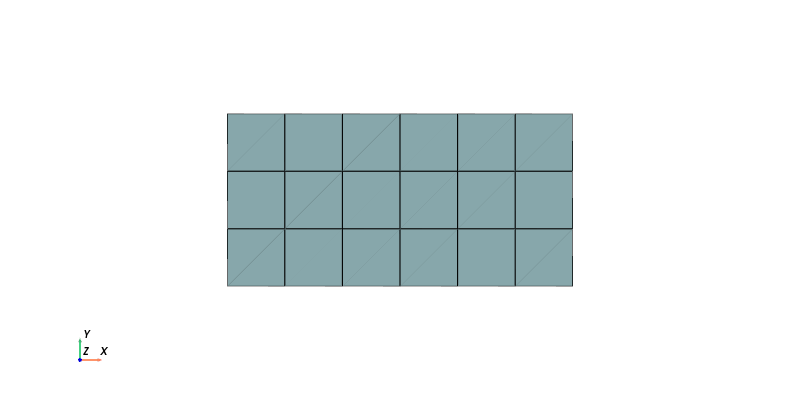

In [4]:
import pyvista as pv
pv.set_jupyter_backend('static')

# Create a simple mesh (plane mesh)
mesh = pv.Plane(direction=(0,0,1), i_size=2, j_size=1, i_resolution=6, j_resolution=3)
mesh = mesh.cast_to_unstructured_grid() # we will be using unstructured grid for FEBio
mesh.plot(show_edges=True, window_size=(800, 400), cpos='xy')

In Pyvista, an unstructured grid is defined as "points" (nodes) and "cells" (elements). We can access them like this: 

In [5]:
mesh.points

pyvista_ndarray([[-1.        , -0.5       ,  0.        ],
                 [-0.6666667 , -0.5       ,  0.        ],
                 [-0.33333334, -0.5       ,  0.        ],
                 [ 0.        , -0.5       ,  0.        ],
                 [ 0.33333334, -0.5       ,  0.        ],
                 [ 0.6666667 , -0.5       ,  0.        ],
                 [ 1.        , -0.5       ,  0.        ],
                 [-1.        , -0.16666667,  0.        ],
                 [-0.6666667 , -0.16666667,  0.        ],
                 [-0.33333334, -0.16666667,  0.        ],
                 [ 0.        , -0.16666667,  0.        ],
                 [ 0.33333334, -0.16666667,  0.        ],
                 [ 0.6666667 , -0.16666667,  0.        ],
                 [ 1.        , -0.16666667,  0.        ],
                 [-1.        ,  0.16666667,  0.        ],
                 [-0.6666667 ,  0.16666667,  0.        ],
                 [-0.33333334,  0.16666667,  0.        ],
              

In [6]:
mesh.cells_dict

{9: array([[ 0,  1,  8,  7],
        [ 1,  2,  9,  8],
        [ 2,  3, 10,  9],
        [ 3,  4, 11, 10],
        [ 4,  5, 12, 11],
        [ 5,  6, 13, 12],
        [ 7,  8, 15, 14],
        [ 8,  9, 16, 15],
        [ 9, 10, 17, 16],
        [10, 11, 18, 17],
        [11, 12, 19, 18],
        [12, 13, 20, 19],
        [14, 15, 22, 21],
        [15, 16, 23, 22],
        [16, 17, 24, 23],
        [17, 18, 25, 24],
        [18, 19, 26, 25],
        [19, 20, 27, 26]], dtype=int64)}

In [7]:
print(f"Number of nodes: {mesh.points.shape[0]}")
print(f"Number of elements: {mesh.cells_dict[pv.CellType.QUAD].shape[0]}")

Number of nodes: 28
Number of elements: 18


In [8]:
from febio_python.core import Nodes, Elements
# Create nodes
nodes = Nodes(name="plane", coordinates=mesh.points)
# Create elements
elements = Elements(name="plane_elements",
                    mat="1",
                    part="Part1",
                    type="QUAD",
                    connectivity=mesh.cells_dict[pv.CellType.QUAD.value],
                    )
# Add nodes and elements to the feb object (need to be lists)
feb.add_nodes([nodes])
feb.add_elements([elements])

We can now see that we have two 'Mesh' items:

In [9]:
feb

Feb40(4.0):
-> Module: solid
-> Control: 12
-> Material: 0
-> Globals: 1
-> Mesh: 2
-> MeshDomains: 0
-> MeshData: 0
-> Boundary: 0
-> Loads: 0
-> Discrete: 0
-> Output: 1
-> LoadData: 0

We can further inspect them:

In [10]:
feb.inspect_nodes_and_elements()

--> Nodes 'plane': 28
--> Elements 'plane_elements': 18



### Modfying nodes/elements

Oh no! We have defined a too coarse mesh! Let's create a fine mesh and update our feb.

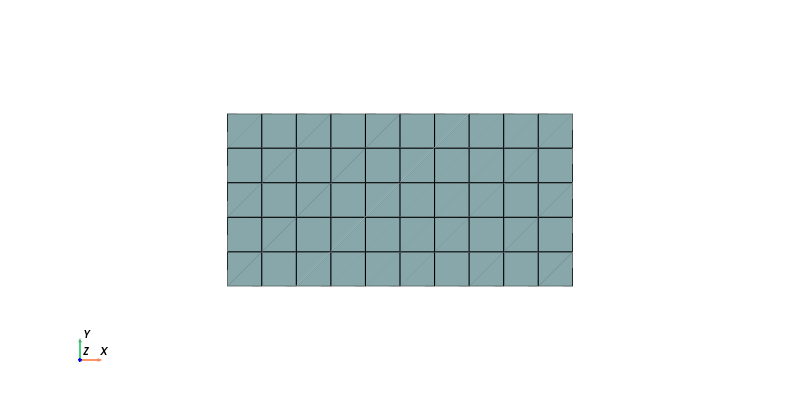

In [11]:
# Create a simple mesh (plane mesh)
mesh = pv.Plane(direction=(0,0,1), i_size=2, j_size=1, i_resolution=10, j_resolution=5)
mesh = mesh.cast_to_unstructured_grid() # we will be using unstructured grid for FEBio
mesh.plot(show_edges=True, window_size=(800, 400), cpos='xy')

In [12]:
print(f"Number of nodes: {mesh.points.shape[0]}")
print(f"Number of elements: {mesh.cells_dict[pv.CellType.QUAD].shape[0]}")

Number of nodes: 66
Number of elements: 50


Note that if we use the function "ADD" again, it will add the new nodes to the existing nodes in the same mesh. This is used when we are creating mesh in an iterative process. Let's try:

In [13]:
# Create nodes
nodes = Nodes(name="plane", coordinates=mesh.points)
# Create elements
elements = Elements(name="plane_elements",
                    mat="1",
                    part="Part1",
                    type="QUAD",
                    connectivity=mesh.cells_dict[pv.CellType.QUAD.value],
                    )
# Add nodes and elements to the feb object (need to be lists)
feb.add_nodes([nodes])
feb.add_elements([elements])
# Inspect nodes and elements
feb.inspect_nodes_and_elements()

--> Nodes 'plane': 94
--> Elements 'plane_elements': 68



You can see that it had inscrease the number of nodes/elements. But this is not what we are looking for.
Let's clean the feb data and add it again:

In [14]:
feb.clear_nodes()
feb.clear_elements()
feb

Feb40(4.0):
-> Module: solid
-> Control: 12
-> Material: 0
-> Globals: 1
-> Mesh: 0
-> MeshDomains: 0
-> MeshData: 0
-> Boundary: 0
-> Loads: 0
-> Discrete: 0
-> Output: 1
-> LoadData: 0

In [15]:
feb.add_nodes([nodes])
feb.add_elements([elements])
feb.inspect_nodes_and_elements()

--> Nodes 'plane': 66
--> Elements 'plane_elements': 50



Is there another method? We need triangle elements!! Also, What if we have multiple nodes or elements and we do not want to delete all of them and just update the existing ones? Let's create another mesh and update the 'plane' mesh in the feb file.

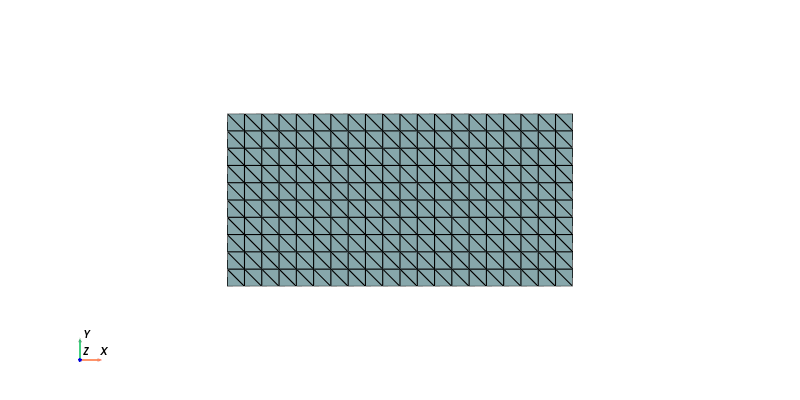

In [16]:
# Create a simple mesh (plane mesh)
mesh = pv.Plane(direction=(0,0,1), i_size=2, j_size=1, i_resolution=20, j_resolution=10)
mesh = mesh.triangulate() # we will be using unstructured grid for FEBio
mesh = mesh.cast_to_unstructured_grid() # we will be using unstructured grid for FEBio
mesh.plot(show_edges=True, window_size=(800, 400), cpos='xy')

In [17]:
print(f"Number of nodes: {mesh.points.shape[0]}")
print(f"Number of elements: {mesh.cells_dict[pv.CellType.TRIANGLE].shape[0]}")

Number of nodes: 231
Number of elements: 400


In [18]:
# Create nodes
nodes = Nodes(name="plane", coordinates=mesh.points)
# Create elements
elements = Elements(name="plane_elements",
                    mat="1",
                    part="Part1",
                    type="TRIANGLE",
                    connectivity=mesh.cells_dict[pv.CellType.TRIANGLE.value],
                    )
# Add nodes and elements to the feb object (need to be lists)
feb.update_nodes([nodes])
feb.update_elements([elements])
# Inspect nodes and elements
feb.inspect_nodes_and_elements()

--> Nodes 'plane': 231
--> Elements 'plane_elements': 400



### Adding Mesh Domains

In [19]:
from febio_python.core import ShellDomain

# create a shell domain
shell = ShellDomain(
    id=1,
    name="plane_elements", # this must match one of the element names
    mat="plane material", # this must match one of the material names
    type="elastic-shell", # type of shell element
    shell_normal_nodal = 1, # normal to the shell
    shell_thickness=0.01, # thickness of the shell
    )
feb.add_mesh_domains([shell])

### Adding Load

Let's try adding a shear load to the mesh:

In [20]:
import numpy as np
from febio_python.core import NodalLoad, LoadCurve, NodeSet

# First, let's select the nodeset to apply the load.
# we will add load to the nodes at the right edge of the mesh
x_values = mesh.points[:, 0]
selected_nodes = np.where(x_values == x_values.max())[0]

# Create a nodeset
nodeset = NodeSet(name="right_edge", ids=selected_nodes)
# Create a nodal load
shear_load = NodalLoad(node_set="right_edge",
                       dof="y",
                       scale=-25.0, # negative value means force is pointing in the negative direction
                       load_curve=1,
                       )
# Create a load curve
load_curve = LoadCurve(id=1, interpolate_type="smooth", data=[(0, 0), (1, 1)])

# Add nodeset, nodal load and load curve to the feb object
feb.add_node_sets([nodeset])
feb.add_nodal_loads([shear_load])
feb.add_load_curves([load_curve])
feb

Feb40(4.0):
-> Module: solid
-> Control: 12
-> Material: 0
-> Globals: 1
-> Mesh: 3
-> MeshDomains: 1
-> MeshData: 0
-> Boundary: 0
-> Loads: 1
-> Discrete: 0
-> Output: 1
-> LoadData: 1

Let's try to add a non-linear load now. Pointing in the x-direction

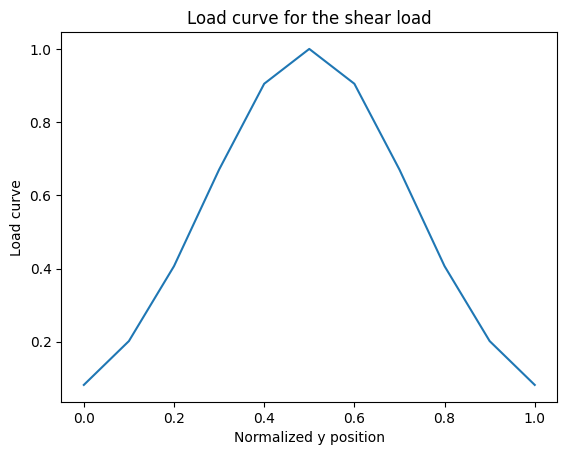

Feb40(4.0):
-> Module: solid
-> Control: 12
-> Material: 0
-> Globals: 1
-> Mesh: 3
-> MeshDomains: 1
-> MeshData: 1
-> Boundary: 0
-> Loads: 2
-> Discrete: 0
-> Output: 1
-> LoadData: 1

In [21]:
# first, get the y position of the nodes
y_values = mesh.points[selected_nodes, 1]
# then, normalize the y values, so that we can use them as 'maps'
y_values = (y_values - y_values.min()) / (y_values.max() - y_values.min())
# now, create a normal distribution curve using the y values, centered at
# middle of the y values (0.5)
tensile_load_map = np.exp(-((y_values - 0.5) ** 2) / 0.1)
# plot the load curve
import matplotlib.pyplot as plt
plt.plot(y_values, tensile_load_map)
plt.xlabel("Normalized y position")
plt.ylabel("Load curve")
plt.title("Load curve for the shear load")
plt.show()

# Create a nodal load
tensile_load = NodalLoad(node_set="right_edge",
                         dof="x",
                       scale=100.0*tensile_load_map, #
                       load_curve=1,
                       )
feb.add_nodal_loads([tensile_load])
feb

### Add boundary condition

Now, let's fix the left boundary of the mesh. We will be applying fixed condition to restrain the mesh in all coordinates. In addition, since this is a simple plane mesh, we will apply constraint in z (for all nodes) and rotation (shell constrain) for all the left nodes.

In [22]:
from febio_python.core import ZeroDisplacementCondition, ZeroShellDisplacementCondition

# Fix the left edge of the mesh
x_values = mesh.points[:, 0]
selected_nodes = np.where(x_values == x_values.min())[0]
all_nodes = np.arange(mesh.points.shape[0]) # used to fix all nodes in the z direction
# Create nodesets
left_nodeset = NodeSet(name="left_edge", ids=selected_nodes)
all_nodeset = NodeSet(name="all_nodes", ids=all_nodes)
# Create a fix condition
left_fix_condition = ZeroDisplacementCondition(dof="x,y,z", node_set="left_edge")
left_shell_fix_condition = ZeroShellDisplacementCondition(dof="sx,sy,sz", node_set="left_edge")
# we will
all_fix_condition = ZeroDisplacementCondition(dof="z", node_set="all_nodes")

# Add nodeset and fix condition to the feb object
feb.add_node_sets([left_nodeset, all_nodeset])
feb.add_boundary_conditions([left_fix_condition, left_shell_fix_condition, all_fix_condition])

### Adding Material

Now, let's add a material. We will use simple Isotropic-Elastic.

In [23]:
from febio_python.core import Material

mat = Material(
    id=1,
    type="isotropic elastic",
    name="plane material",
    parameters=dict(
        E=1e6,
        v=0.3,
        density=1,
    )
)

feb.add_materials([mat])

### Add Element data

In [24]:
from febio_python.core import ElementData

shell_thickness = ElementData(
    name="Element thickness",
    elem_set="plane_elements",
    data=np.full((mesh.n_cells, 3), 0.01),
    ids=np.arange(0, mesh.n_cells + 1),
)
feb.add_element_data([shell_thickness])

## Running FEB

Uncomment and run the code below:

In [25]:
# from febio_python.feb import run
# # Save the FEB file
# feb.write("plane_mesh_v40.feb")
# run("plane_mesh_v40.feb")

## Reading XPLT

In [26]:
from febio_python import Xplt

xplt = Xplt("plane_mesh_v40.xplt")
xplt

Xplt object [1977296799008]:
=== xplt_mesh: ===
-Nodes:
--->None: (231, 3)
-Elements:
--->None: (400, 3)
=== States: ===
-Nodes:
--->displacement: (11, 231, 3)
-Elements:
--->Lagrange strain: (11, 400, 6)
--->stress: (11, 400, 6)
-Surfaces:

### Example properties

In [27]:
xplt.nodes # list of Nodes objects

[Nodes(name=None, coordinates=array([[-1.        , -0.5       ,  0.        ],
        [-0.89999998, -0.5       ,  0.        ],
        [-0.80000001, -0.5       ,  0.        ],
        [-0.69999999, -0.5       ,  0.        ],
        [-0.60000002, -0.5       ,  0.        ],
        [-0.5       , -0.5       ,  0.        ],
        [-0.40000001, -0.5       ,  0.        ],
        [-0.30000001, -0.5       ,  0.        ],
        [-0.2       , -0.5       ,  0.        ],
        [-0.1       , -0.5       ,  0.        ],
        [ 0.        , -0.5       ,  0.        ],
        [ 0.1       , -0.5       ,  0.        ],
        [ 0.2       , -0.5       ,  0.        ],
        [ 0.30000001, -0.5       ,  0.        ],
        [ 0.40000001, -0.5       ,  0.        ],
        [ 0.5       , -0.5       ,  0.        ],
        [ 0.60000002, -0.5       ,  0.        ],
        [ 0.69999999, -0.5       ,  0.        ],
        [ 0.80000001, -0.5       ,  0.        ],
        [ 0.89999998, -0.5       ,  0.  

In [28]:
xplt.elements # list of Elements objects

[Elements(name=None, type='TRIANGLE', connectivity=array([[  0,   1,  21],
        [ 22,  21,   1],
        [  1,   2,  22],
        ...,
        [229, 228, 208],
        [208, 209, 229],
        [230, 229, 209]]), ids=array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139,

In [29]:
xplt.states # list of States objects

States(nodes=[StateData(name='displacement', dom=-1, data=array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.00220876, -0.00138848,  0.        ],
        [-0.0044777 , -0.00291381,  0.        ],
        ...,
        [ 0.03501934, -0.07832458,  0.        ],
        [ 0.03535859, -0.08439115,  0.        ],
        [ 0.03562101, -0.09075736,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.0040143 , -0.00251072,  0.        ],
        [-0.00812449, -0.00527578,  0.        ],
        ...,
        [ 0.06155637, -0.14323959,  0.        ],
        [ 0.06199993, -0.15412821,  0.        ],
        [ 0.06229447, -0.16563064,  0.        ]],

       ...,

  

### States data:

In [30]:
xplt.states.nodes[0]

StateData(name='displacement', dom=-1, data=array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.00220876, -0.00138848,  0.        ],
        [-0.0044777 , -0.00291381,  0.        ],
        ...,
        [ 0.03501934, -0.07832458,  0.        ],
        [ 0.03535859, -0.08439115,  0.        ],
        [ 0.03562101, -0.09075736,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.0040143 , -0.00251072,  0.        ],
        [-0.00812449, -0.00527578,  0.        ],
        ...,
        [ 0.06155637, -0.14323959,  0.        ],
        [ 0.06199993, -0.15412821,  0.        ],
        [ 0.06229447, -0.16563064,  0.        ]],

       ...,

       [[ 0.    

In [31]:
xplt.states.elements[0]

StateData(name='Lagrange strain', dom=0, data=array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-2.17677094e-02,  0.00000000e+00,  3.74327949e-03,
         -6.93582371e-03, -4.37995950e-05, -2.12121537e-04],
        [-1.44304177e-02,  4.09667706e-03,  5.80157526e-03,
         -1.21883943e-03,  5.601

## FEBio Container

In [32]:
from febio_python import FEBioContainer

container = FEBioContainer(feb=feb,
                           xplt=xplt
                           )

Can also load from a file directly:

In [33]:
container = FEBioContainer(feb="plane_mesh_v30.feb",
                           xplt="plane_mesh_v30.xplt"
                           )

ValueError: Content was identified as string, but could not be parsed. Please, verify.

In [ ]:
container.feb

In [ ]:
container.xplt

In [ ]:
container.nodes

## Ploting Feb or Xplt

In [ ]:
from febio_python.utils.pyvista_utils import febio_to_pyvista

grids_list = febio_to_pyvista(container)
len(grids_list)

In [ ]:
grids_list[-1].plot(cpos='xy', show_edges=True, scalars="stress")

You can also quickly convert all cell data to node data:

In [ ]:
last_grid_as_nodal_data = grids_list[-1].cell_data_to_point_data()
last_grid_as_nodal_data.plot(cpos='xy', show_edges=True, scalars="stress")

In [ ]:
last_grid_as_nodal_data

When using the FEBio container, we have access to both Feb and Xplt data. This means that we can retrieve nodal load, boundary conditions, etc. Here is a cool plot that we can do:

In [ ]:
plotter = pv.Plotter()
strain_xx = last_grid_as_nodal_data["Lagrange strain"][:, 0]
fixed_nodes = last_grid_as_nodal_data["fix"].sum(1)

plotter.add_mesh(last_grid_as_nodal_data,
                 scalars=strain_xx,
                 cmap="coolwarm",
                 show_edges=True,
                 scalar_bar_args={"title": "Strain - XX"})
plotter.add_mesh(last_grid_as_nodal_data.points,
                 scalars=fixed_nodes,
                 cmap="viridis",
                 style="points",
                 point_size=10,
                 render_points_as_spheres=True, show_scalar_bar=False)
plotter.add_arrows(last_grid_as_nodal_data.points,
                   last_grid_as_nodal_data["nodal_load"],
                   mag=5e-3, # This controls the mag of the arrows. Not the actual load. There may be a better way to control this.
                   show_scalar_bar=False,
                   color="orange")
plotter.show(cpos="xy")